In [ ]:
from models import *
from util import *

In [ ]:
MOTHER_PATH = "."

DIST_DICT = {
    "gaussian": "g",
    "uniform": "u"
}

AGENT_DICT = {
    "mab_ucb": r"UCB($\delta$)",
    "linucb": "LinUCB",
    "lints": "LinTS",
    "rolf_lasso": "RoLF-Lasso (Ours)",
    "rolf_ridge": "RoLF-Ridge (Ours)",
    "dr_lasso": "DRLasso"
}

In [ ]:
def feature_generator(case:int,
                      d_z:int,
                      d:int,
                      K:int,
                      random_state:int):
    ## sample the true, observable, and unobservable features
    np.random.seed(random_state)
    d_u = d_z - d   # dimension of unobserved features
    assert case in [1, 2, 3], "There exists only Case 1, 2, and 3."
    if case == 1:
        ## R(U) ⊆ R(X)
        """For two matrices A and B,
        if each row of A can be expressed as a linear combination of the rows of B,
        then R(A) ⊆ R(B)"""
        # First generate X
        X = np.random.multivariate_normal(mean=np.zeros(d),
                                          cov=np.eye(d),
                                          size=K).T # (d, K)

        # Generate a coefficient matrix C
        C = np.random.uniform(low=-1/np.pi,
                              high=1/np.pi,
                              size=(d_u, d)) # (d_u, d)

        # Compute U as a multiplication between C and X
        U = C @ X # (d_u, K)
        Z = np.concatenate([X, U], axis=0) # (k, K)))

    elif case == 2:
        ## R(X) ⊆ R(U)
        # First generate U
        U = np.random.multivariate_normal(mean=np.zeros(d_u),
                                          cov=np.eye(d_u),
                                          size=K).T # (d_u, K)

        # Generate a coefficient matrix C
        C = np.random.uniform(low=-1/np.pi,
                              high=1/np.pi,
                              size=(d, d_u)) # (d, d_u)

        # Compute U as a multiplication between C and X
        X = C @ U # (d, K)
        Z = np.concatenate([X, U], axis=0) # (k, K)))

    elif case == 3:
        ## Default case
        Z = np.random.multivariate_normal(mean=np.zeros(d_z),
                                          cov=np.eye(d_z),
                                          size=K).T   # (k, K)
        X = Z[:d, :]    # (d, K)

    return Z, X

In [ ]:
def run_trials(agent_type:str,
               trials:int,
               horizon:int,
               k:int,
               d:int,
               arms:int,
               noise_std:float,
               case:int,
               random_state:int,
               verbose:bool,
               fname:str):

    ## run and collect the regrets
    regret_container = np.zeros(trials, dtype=object)
    for trial in range(trials):
        if random_state is not None:
            random_state_ = random_state + (513 * trial)
        else:
            random_state_ = None
        print(f"Trial : {trial}, SEED : {random_state_}")

        if agent_type == "linucb":
            agent = LinUCB(d=d,
                           lbda=0.6,
                           delta=1e-4)

        elif agent_type == "lints":
            agent = LinTS(d=d,
                          lbda=0.6,
                          horizon=horizon,
                          reward_std=noise_std,
                          delta=1e-4)

        elif agent_type == "mab_ucb":
            agent = UCBDelta(n_arms=arms,
                             delta=1e-4)

        elif agent_type == "rolf_lasso":
            agent = RoLFLasso(d=d,
                                arms=arms,
                                p=0.6,
                                delta=1e-4,
                                sigma=noise_std,
                                random_state=random_state_,
                                explore=True,
                                init_explore=3*arms)

        elif agent_type == "rolf_ridge":
            agent = RoLFRidge(d=d,
                                arms=arms,
                                p=0.6,
                                delta=1e-4,
                                sigma=noise_std,
                                random_state=random_state_,
                                explore=True,
                                init_explore=3*arms)

        elif agent_type == "dr_lasso":
            agent = DRLassoBandit(d=d,
                                  arms=arms,
                                  lam1=1.,
                                  lam2=0.5,
                                  zT=10,
                                  tr=True)

        ## sample features
        Z, X = feature_generator(case=case,
                                 d_z=k,
                                 d=d,
                                 K=arms,
                                 random_state=random_state_+1)

        ## sample reward parameter after augmentation and compute the expected rewards
        reward_param = param_generator(dimension=k,
                                       distribution="uniform",
                                       disjoint=True,
                                       bound=1.,
                                       bound_type="l1",
                                       uniform_rng=[-0.5, 0.5],
                                       random_state=random_state_)

        ## (K, ) vector with the maximum absolute value does not exceed 1
        exp_rewards = bounding(type="param",
                               v=Z.T @ reward_param,
                               bound=1.,
                               norm_type="lsup")

        if isinstance(agent, LinUCB) or isinstance(agent, LinTS) or isinstance(agent, DRLassoBandit):
            data = X.T  # (K, d)
        else:
            # (K, K-d) matrix and each column vector denotes the orthogonal basis if K > d
            # (K, K) matrix from singular value decomposition if d > K
            basis = orthogonal_complement_basis(X)

            d, K = X.shape
            if d <= K:
                x_aug = np.hstack((X.T, basis)) # augmented into (K, K) matrix and each row vector denotes the augmented feature
                data = x_aug
            else:
                data = basis

        # print(f"Agent : {agent.__class__.__name__}\t data shape : {data.shape}")

        regrets = run(trial=trial,
                      agent=agent,
                      horizon=horizon,
                      exp_rewards=exp_rewards,
                      x=data,
                      noise_dist="gaussian",
                      noise_std=noise_std,
                      random_state=random_state_,
                      verbose=verbose,
                      fname=fname)

        regret_container[trial] = regrets
    return regret_container

In [ ]:
def run(trial:int,
        agent:Union[MAB, ContextualBandit],
        horizon:int,
        exp_rewards:np.ndarray,
        x:np.ndarray,
        noise_dist:str,
        noise_std:float,
        random_state:int,
        verbose:bool,
        fname:str):

    # x: augmented feature if the agent is RoLF (K, K)
    regrets = np.zeros(horizon, dtype=float)

    for t in range(horizon):
        if random_state is not None:
            random_state_ = random_state + int(113 * t)
        else:
            random_state_ = None

        ## compute the optimal action
        optimal_action = np.argmax(exp_rewards)
        optimal_reward = exp_rewards[optimal_action]

        ## choose the best action
        noise = subgaussian_noise(distribution=noise_dist,
                                  size=1,
                                  std=noise_std,
                                  random_state=random_state_)

        if isinstance(agent, ContextualBandit):
            chosen_action = agent.choose(x)
        else:
            chosen_action = agent.choose()
        chosen_reward = exp_rewards[chosen_action] + noise

        ## compute the regret
        regrets[t] = optimal_reward - exp_rewards[chosen_action]

        ## update the agent
        if isinstance(agent, ContextualBandit):
            agent.update(x=x, r=chosen_reward)
        else:
            agent.update(a=chosen_action, r=chosen_reward)

    return np.cumsum(regrets)

In [ ]:
def show_result(regrets:dict,
                horizon:int,
                figsize:tuple=(6, 5),
                fontsize=11):

    fig, ax = plt.subplots(figsize=figsize)

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'black']
    period = horizon // 10

    z_init = len(colors)
    # Plot the graph for each algorithm with error bars
    for i, (color, (key, item)) in enumerate(zip(colors, regrets.items())):
        rounds = np.arange(horizon)
        mean = np.mean(item, axis=0)
        std = np.std(item, axis=0, ddof=1)

        # Display the line with markers and error bars periodically
        ax.errorbar(rounds[::period], mean[::period], yerr=std[::period], label=f"{key}",
                    fmt='s', color=color, capsize=3, elinewidth=1, zorder=z_init-i)

        # Display the full line without periodic markers
        ax.plot(rounds, mean, color=color, linewidth=2, zorder=z_init-i)

    ax.grid(True)
    ax.set_xlabel(r"Round ($t$)")
    ax.set_ylabel("Cumulative Regret")
    ax.legend(loc="upper left", fontsize=fontsize)

    fig.tight_layout()
    return fig


In [ ]:
## hyper-parameters
SEED = 131
arms = 10
k = 40
d = 10
T = 1200
AGENTS = [
    "rolf_lasso",
    "rolf_ridge",
    "dr_lasso",
    "linucb",
    "lints",
    "mab_ucb"
]
case = 1
trials = 5
fname = "test"

Trial : 0, SEED : 131Trial : 0, SEED : 131Trial : 0, SEED : 131Trial : 0, SEED : 131Trial : 0, SEED : 131Trial : 0, SEED : 131





Trial : 1, SEED : 644
Trial : 2, SEED : 1157
Trial : 3, SEED : 1670
Trial : 4, SEED : 2183
Trial : 1, SEED : 644
Trial : 1, SEED : 644
Trial : 2, SEED : 1157
Trial : 3, SEED : 1670
Trial : 2, SEED : 1157
Trial : 4, SEED : 2183
Trial : 3, SEED : 1670
Trial : 4, SEED : 2183
Trial : 1, SEED : 644
Trial : 2, SEED : 1157
Trial : 1, SEED : 644
Trial : 3, SEED : 1670
Trial : 2, SEED : 1157
Trial : 4, SEED : 2183
Trial : 3, SEED : 1670
Trial : 4, SEED : 2183
Trial : 1, SEED : 644
Trial : 2, SEED : 1157
Trial : 3, SEED : 1670
Trial : 4, SEED : 2183


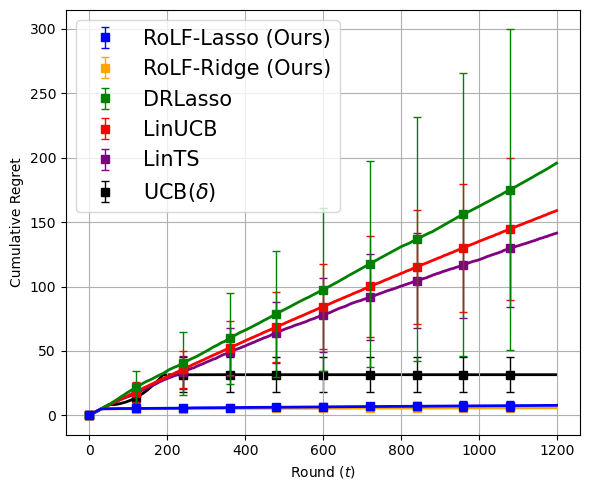

In [ ]:
def run_agent(agent_type):
    regrets = run_trials(
        agent_type=agent_type,
        trials=trials,
        horizon=T,
        k=k,
        d=d,
        arms=arms,
        noise_std=0.03,
        case=case,
        random_state=SEED,
        verbose=False,
        fname=fname
    )
    key = AGENT_DICT[agent_type]
    return key, regrets

# Parallel execution using ProcessPoolExecutor
regret_results = dict()
with ProcessPoolExecutor(max_workers=8) as executor:
    results = executor.map(run_agent, AGENTS)

# Collect results
for key, regrets in results:
    regret_results[key] = regrets

fig = show_result(regrets=regret_results,
                    horizon=T,
                    fontsize=15)

fig.show()

In [ ]:
## hyper-parameters
SEED = 97
arms = 15
k = 40
d = 20
T = 1200
AGENTS = [
    "rolf_lasso",
    "rolf_ridge",
    "dr_lasso",
    "linucb",
    "lints",
    "mab_ucb"
]
case = 3
trials = 5
fname = "test_2"

Trial : 0, SEED : 97Trial : 0, SEED : 97Trial : 0, SEED : 97Trial : 0, SEED : 97Trial : 0, SEED : 97Trial : 0, SEED : 97





Trial : 1, SEED : 610
Trial : 2, SEED : 1123
Trial : 3, SEED : 1636
Trial : 4, SEED : 2149
Trial : 1, SEED : 610
Trial : 1, SEED : 610
Trial : 2, SEED : 1123
Trial : 2, SEED : 1123
Trial : 3, SEED : 1636
Trial : 3, SEED : 1636
Trial : 4, SEED : 2149
Trial : 4, SEED : 2149
Trial : 1, SEED : 610
Trial : 2, SEED : 1123
Trial : 3, SEED : 1636
Trial : 1, SEED : 610
Trial : 4, SEED : 2149
Trial : 2, SEED : 1123
Trial : 3, SEED : 1636
Trial : 4, SEED : 2149
Trial : 1, SEED : 610
Trial : 2, SEED : 1123
Trial : 3, SEED : 1636
Trial : 4, SEED : 2149


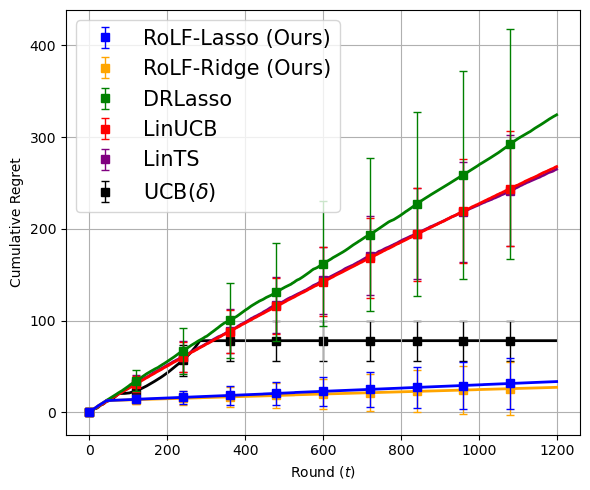

In [ ]:
# Parallel execution using ProcessPoolExecutor
regret_results = dict()
with ProcessPoolExecutor(max_workers=8) as executor:
    results = executor.map(run_agent, AGENTS)

# Collect results
for key, regrets in results:
    regret_results[key] = regrets

fig = show_result(regrets=regret_results,
                    horizon=T,
                    fontsize=15)

fig.show()